In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point
import os
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

/tmp/ipykernel_6187/2360698793.py:39: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf['Datasets'] == 2].plot(ax=ax, color='black', marker='o', markersize=marker_size_on_plot,


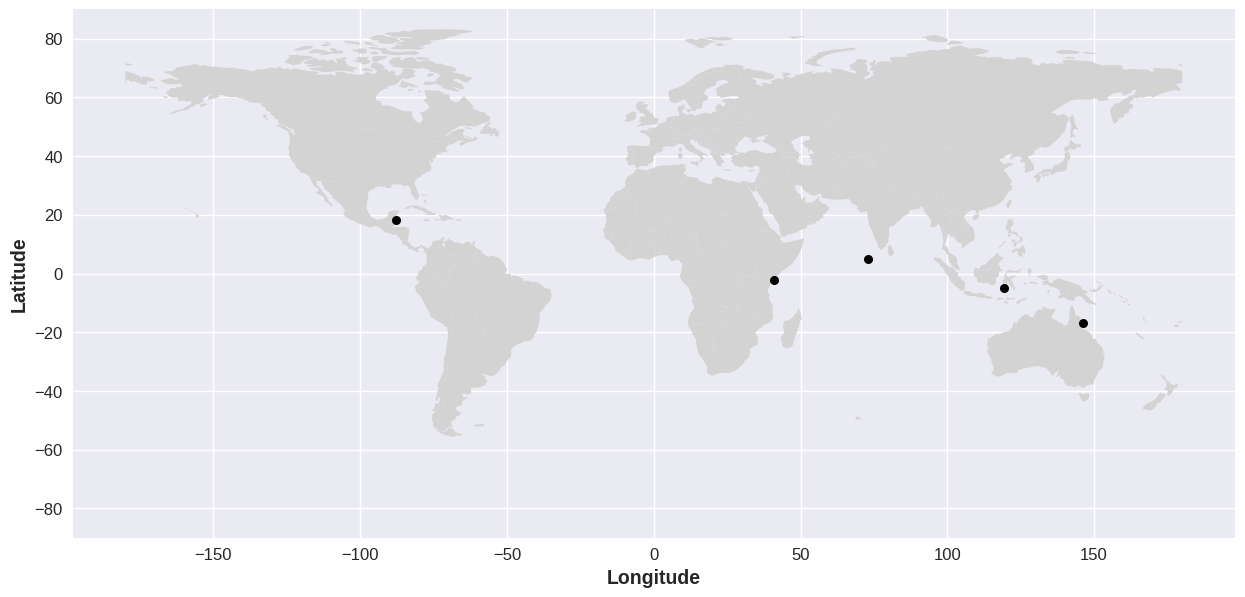

In [ ]:
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")

# Data preparation
data = {
    'Location': ['Australia', 'Indonesia', 'Kenya', 'Maldives', 'Mexico'],
    'Latitude': [-16.84781, -4.93154, -2.21474, 4.8864, 18.333292],
    'Longitude': [146.22798, 119.31577,  41.01613, 72.9278, -87.808362],
    'Datasets': [1, 1, 1, 1, 1]
}

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    data, 
    geometry=[Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
)

# World basemap
base_map_path = os.path.join(BASE_DIR, "marrs_acoustics/code/scratch/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world = gpd.read_file(base_map_path)

# Clipping the world map to the specified latitude range
world_clipped = world.cx[:, -60:60]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_clipped.plot(ax=ax, color='lightgrey')

# Set the y-limits (latitude) of the map to -50 to 50
ax.set_ylim(-90, 90)

# Adjust marker size for the plot here
marker_size_on_plot = 30

# Plotting points with thicker black outlines
gdf[gdf['Datasets'] == 1].plot(ax=ax, color='black', marker='o', markersize=marker_size_on_plot, 
                               label='1 Dataset', edgecolor='black', linewidth=1)
gdf[gdf['Datasets'] == 2].plot(ax=ax, color='black', marker='o', markersize=marker_size_on_plot, 
                               label='2 Datasets', edgecolor='black', linewidth=1)

# Title and labels
plt.xlabel('Longitude', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.ylabel('Latitude', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

# Show plot
plt.show()



## Box plot functions globally


In [ ]:
# The map plot above breaks the ability to display, this is a quick fix
%matplotlib inline

/tmp/ipykernel_6187/2588537169.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_6187/2588537169.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


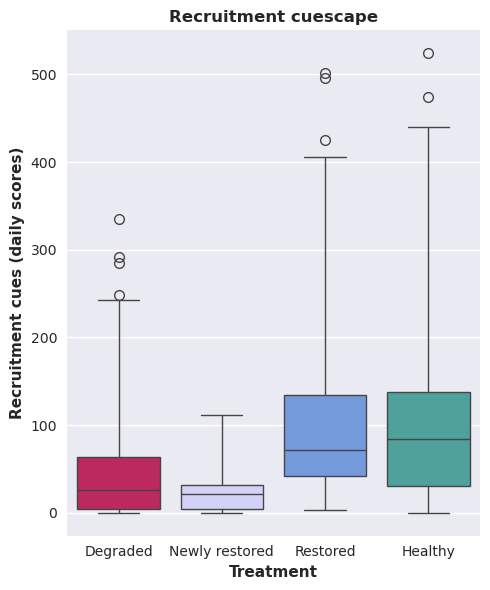

/tmp/ipykernel_6187/2588537169.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_6187/2588537169.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


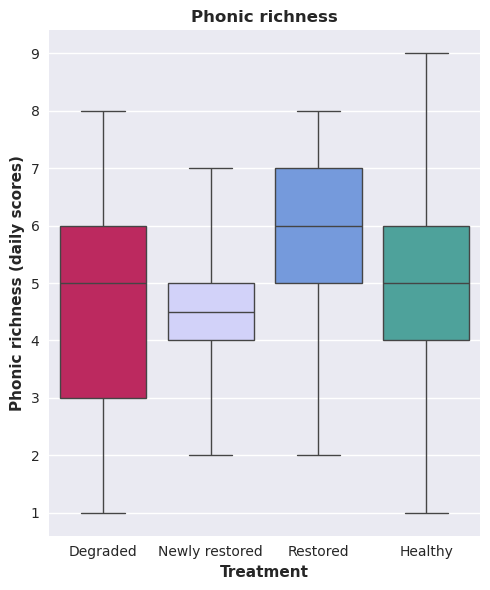

/tmp/ipykernel_6187/2588537169.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_6187/2588537169.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


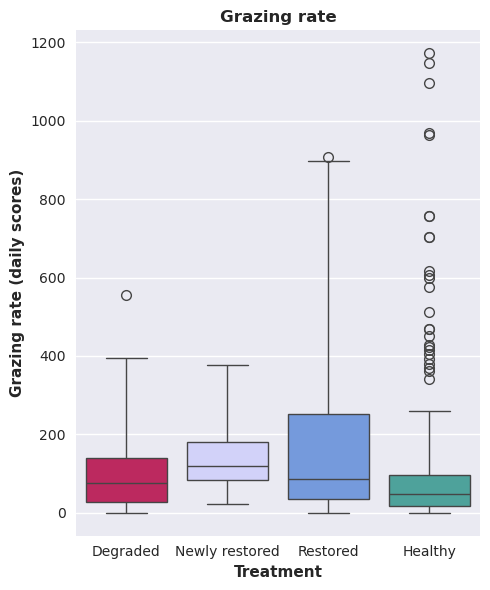

/tmp/ipykernel_6187/2588537169.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_6187/2588537169.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


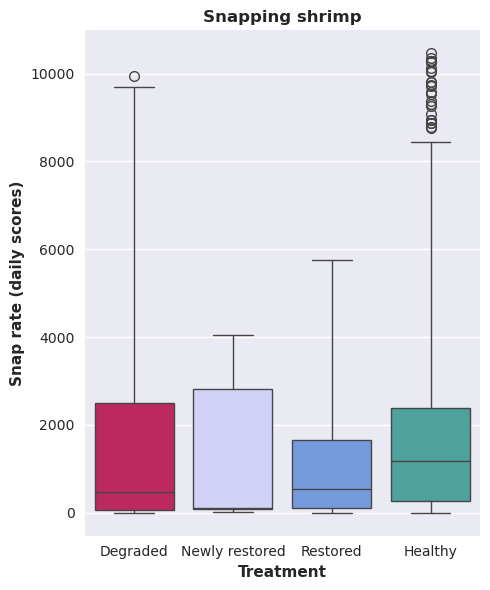

In [77]:
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get path to folder of csv files
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")
csv_dir = os.path.join(BASE_DIR, "marrs_acoustics/data/results/functions")

# Combine treatment order, label, and color in a single dict
TREATMENT_INFO = {
  "degraded": {
      "label": "Degraded",
      "color": "#D41159"
  },
  "newly_restored": {
      "label": "Newly restored",
      "color": "#CCCCFF"
  },
  "restored": {
      "label": "Restored",
      "color": "#6495ED"
  },
  "healthy": {
      "label": "Healthy",
      "color": "#40B0A6"
  }
}

# Extract a list (order) of treatment keys
TREATMENT_ORDER = list(TREATMENT_INFO.keys())

# Build separate dictionaries for labels & colours for Seaborn
TREATMENT_LABELS = {k: v["label"] for k, v in TREATMENT_INFO.items()}
TREATMENT_COLORS = {k: v["color"] for k, v in TREATMENT_INFO.items()}

# CSVs mapping: filename -> config
CSV_MAPPING = {
    "settlement_cuescape.csv": {
        "title": "Recruitment cuescape",
        "exclude_outliers": 6,
        "y-axis title": "Recruitment cues (daily scores)"
    },
    "phonic_richness.csv": {
        "title": "Phonic richness",
        "exclude_outliers": 0,
        "y-axis title": "Phonic richness (daily scores)"
    },
    "graze_count.csv": {
        "title": "Grazing rate",
        "exclude_outliers": 10,
        "y-axis title": "Grazing rate (daily scores)"
    },
    "snaps_count.csv": {
        "title": "Snapping shrimp",
        "exclude_outliers": 10,
        "y-axis title": "Snap rate (daily scores)"
    }
}

def read_data(csv_path: str) -> pd.DataFrame:
  """Read CSV and set 'treatment' as an ordered categorical."""
  df = pd.read_csv(csv_path)
  df["treatment"] = pd.Categorical(
    df["treatment"],
    categories=TREATMENT_ORDER,
    ordered=True
  )
  return df

def plot_box(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    plot_title: str,
    y_axis_label: str,
    exclude_outliers: int = 0,
    fig_width: float = 6,
    fig_height: float = 4,
    whis: float = 1.5
) -> plt.Figure:
  """
  Plot a boxplot of y_col by x_col, optionally excluding
  the top-end outliers. 'whis' controls how far the whiskers extend
  past the quartiles, thus affecting outlier detection (larger = fewer outliers).
  """
  # Exclude top 'exclude_outliers' rows based on y_col
  if exclude_outliers > 0:
    df = df.drop(df.nlargest(exclude_outliers, y_col).index)

  sns.set_style("darkgrid")
  fig, ax = plt.subplots(figsize=(fig_width, fig_height))

  sns.boxplot(
      data=df,
      x=x_col,
      y=y_col,
      order=TREATMENT_ORDER,
      palette=TREATMENT_COLORS,
      whis=3, # How forgiving is the main body to keeping outliers
      ax=ax
  )

  # Label x-axis ticks using our unified labels
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])
  ax.set_xlabel("Treatment", fontweight="bold")
  ax.set_ylabel(y_axis_label, fontweight="bold")
  ax.set_title(plot_title, fontweight="bold")
  ax.legend([], [], frameon=False)

  plt.tight_layout()
  return fig

# Loop through each CSV, read data, then plot
for csv_file, info in CSV_MAPPING.items():
  csv_path = os.path.join(csv_dir, csv_file)
  data_df = read_data(csv_path)

  # Special case for graze_count.csv: exclude 'kenya'
  if csv_file == "graze_count.csv":
    data_df = data_df[data_df["country"].str.lower() != "kenya"]

  fig = plot_box(
      df=data_df,
      x_col="treatment",
      y_col="count",
      plot_title=info["title"],
      y_axis_label=info["y-axis title"],
      exclude_outliers=info["exclude_outliers"],
      fig_width=5,
      fig_height=6,
      whis=1.5
  )
  plt.show()


/tmp/ipykernel_6187/1682735965.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_6187/1682735965.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_6187/1682735965.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


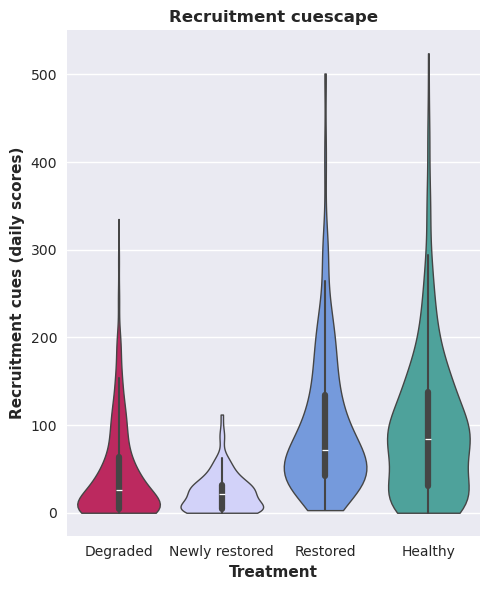

/tmp/ipykernel_6187/1682735965.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_6187/1682735965.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_6187/1682735965.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


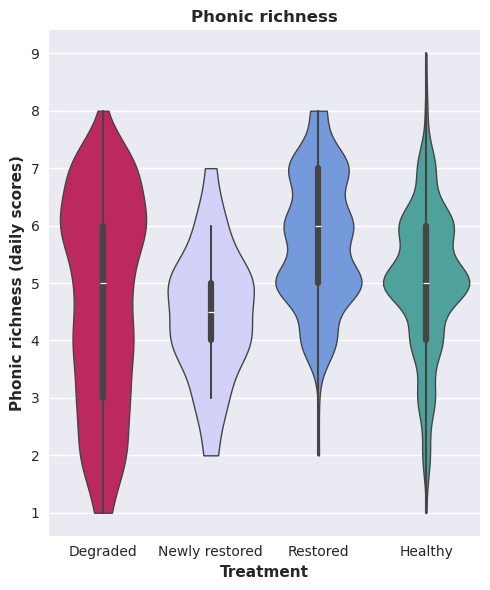

/tmp/ipykernel_6187/1682735965.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_6187/1682735965.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_6187/1682735965.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


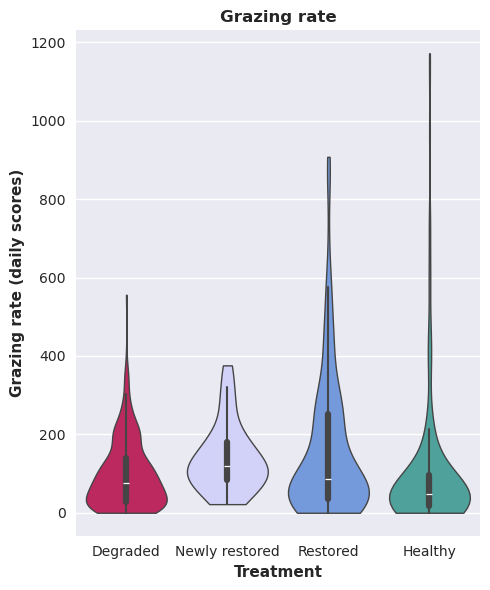

/tmp/ipykernel_6187/1682735965.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_6187/1682735965.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_6187/1682735965.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


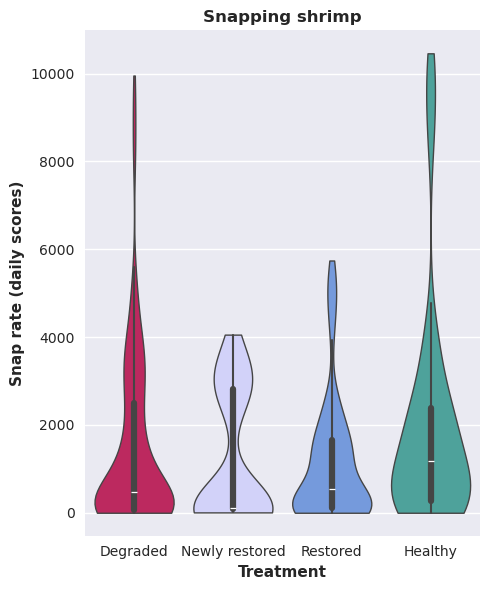

In [74]:
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get path to folder of csv files
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")
csv_dir = os.path.join(BASE_DIR, "marrs_acoustics/data/results/functions")

# Combine treatment order, label, and color in a single dict
# The order here is the order in which they appear in the dict
TREATMENT_INFO = {
  "degraded": {
      "label": "Degraded",
      "color": "#D41159"
  },
  "newly_restored": {
      "label": "Newly restored",
      "color": "#CCCCFF"
  },
  "restored": {
      "label": "Restored",
      "color": "#6495ED"
  },
  "healthy": {
      "label": "Healthy",
      "color": "#40B0A6"
  }
}

# Extract a list (order) of treatment keys
TREATMENT_ORDER = list(TREATMENT_INFO.keys())

# Build separate dictionaries for labels & colours for Seaborn
TREATMENT_LABELS = {k: v["label"] for k, v in TREATMENT_INFO.items()}
TREATMENT_COLORS = {k: v["color"] for k, v in TREATMENT_INFO.items()}

# CSVs mapping: filename -> config
CSV_MAPPING = {
    "settlement_cuescape.csv": {
        "title": "Recruitment cuescape",
        "exclude_outliers": 6,
        "y-axis title": "Recruitment cues (daily scores)"
    },
    "phonic_richness.csv": {
        "title": "Phonic richness",
        "exclude_outliers": 0,
        "y-axis title": "Phonic richness (daily scores)"
    },
    "graze_count.csv": {
        "title": "Grazing rate",
        "exclude_outliers": 10,
        "y-axis title": "Grazing rate (daily scores)"
    },
    "snaps_count.csv": {
        "title": "Snapping shrimp",
        "exclude_outliers": 10,
        "y-axis title": "Snap rate (daily scores)"
    }
}

def read_data(csv_path: str) -> pd.DataFrame:
  """Read CSV and set 'treatment' as an ordered categorical."""
  df = pd.read_csv(csv_path)
  df["treatment"] = pd.Categorical(df["treatment"],
                                   categories=TREATMENT_ORDER,
                                   ordered=True)
  return df

def plot_violin(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    plot_title: str,
    y_axis_label: str,
    exclude_outliers: int = 0,
    fig_width: float = 6,
    fig_height: float = 4,
    cut_val: float = 1.0
) -> plt.Figure:
  """
  Plot a violin plot of y_col by x_col, optionally excluding
  the top-end outliers. 'cut_val' controls how far the violin
  extends beyond the data (lower = less extension).
  """
  # Exclude top 'exclude_outliers' rows based on y_col
  if exclude_outliers > 0:
    df = df.drop(df.nlargest(exclude_outliers, y_col).index)

  sns.set_style("darkgrid")
  fig, ax = plt.subplots(figsize=(fig_width, fig_height))

  sns.violinplot(
      data=df,
      x=x_col,
      y=y_col,
      order=TREATMENT_ORDER,
      palette=TREATMENT_COLORS,  # Use the unified palette
      ax=ax,
      cut=cut_val,
      inner="box",
      linewidth=1,   # Thicker outlines
      width=0.8,     # Wider violins
      scale="width"
  )

  # Label x-axis ticks using our unified labels
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])
  ax.set_xlabel("Treatment", fontweight="bold")
  ax.set_ylabel(y_axis_label, fontweight="bold")
  ax.set_title(plot_title, fontweight="bold")
  ax.legend([], [], frameon=False)

  plt.tight_layout()
  return fig

# Loop through each CSV, read data, then plot
for csv_file, info in CSV_MAPPING.items():
  csv_path = os.path.join(csv_dir, csv_file)
  data_df = read_data(csv_path)

  # Special case for graze_count.csv: exclude 'kenya'
  if csv_file == "graze_count.csv":
    data_df = data_df[data_df["country"].str.lower() != "kenya"]

  fig = plot_violin(
      df=data_df,
      x_col="treatment",
      y_col="count",
      plot_title=info["title"],
      y_axis_label=info["y-axis title"],
      exclude_outliers=info["exclude_outliers"],
      fig_width=5,
      fig_height=6,
      cut_val=0
  )
  plt.show()


## By country

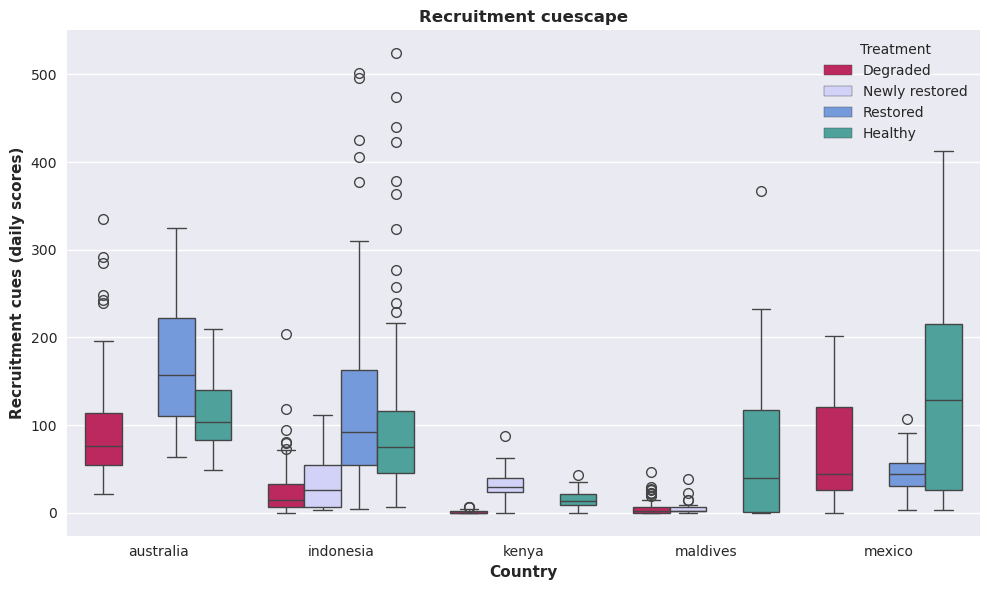

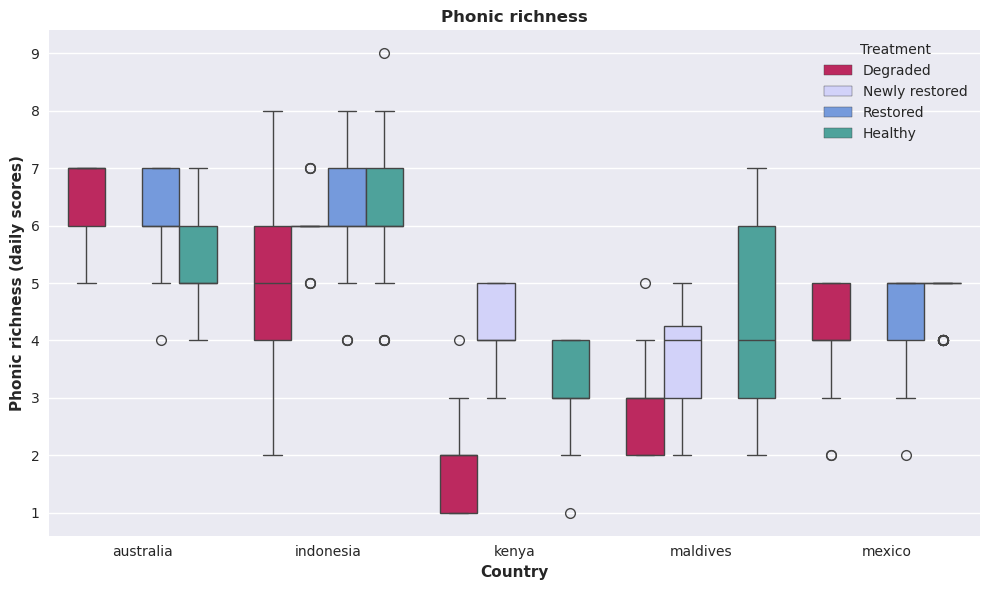

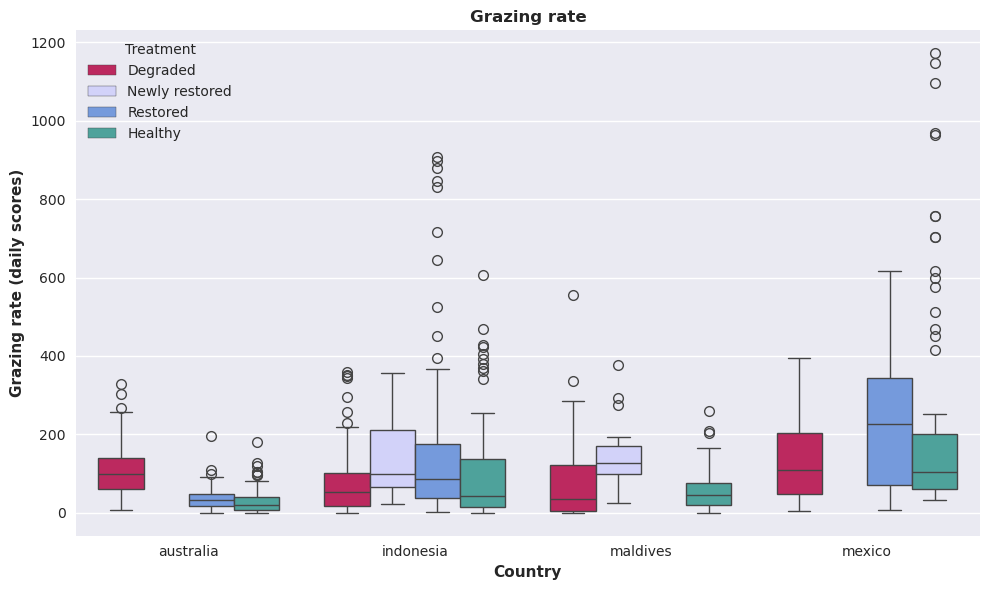

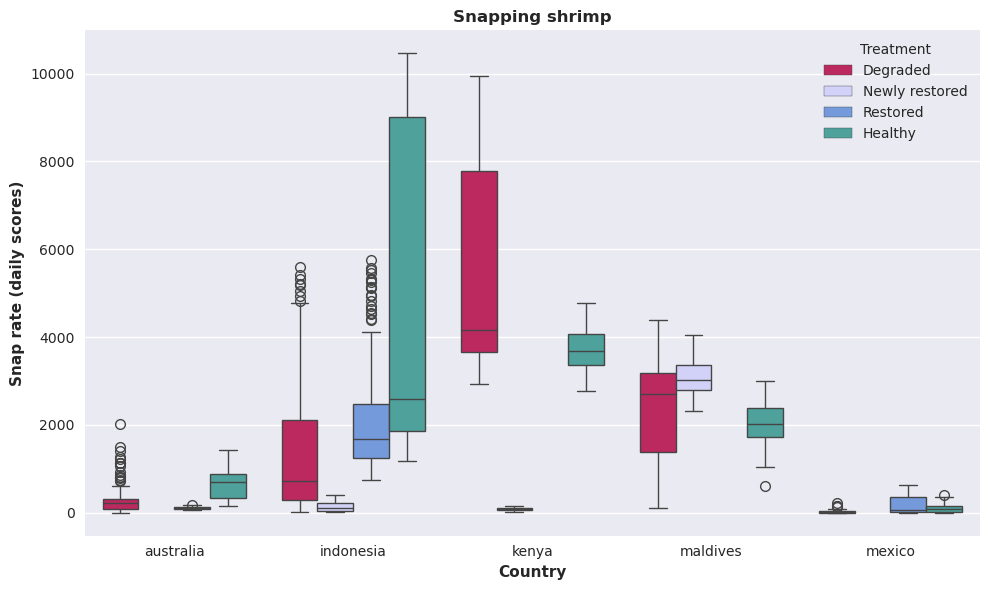

In [78]:
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get path to folder of csv files
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")
csv_dir = os.path.join(BASE_DIR, "marrs_acoustics/data/results/functions")

# Combine treatment order, label, and color in a single dict
TREATMENT_INFO = {
  "degraded": {
      "label": "Degraded",
      "color": "#D41159"
  },
  "newly_restored": {
      "label": "Newly restored",
      "color": "#CCCCFF"
  },
  "restored": {
      "label": "Restored",
      "color": "#6495ED"
  },
  "healthy": {
      "label": "Healthy",
      "color": "#40B0A6"
  }
}

# Extract a list (order) of treatment keys
TREATMENT_ORDER = list(TREATMENT_INFO.keys())

# Build separate dictionaries for labels & colours for Seaborn
TREATMENT_LABELS = {k: v["label"] for k, v in TREATMENT_INFO.items()}
TREATMENT_COLORS = {k: v["color"] for k, v in TREATMENT_INFO.items()}

# CSVs mapping: filename -> config
CSV_MAPPING = {
    "settlement_cuescape.csv": {
        "title": "Recruitment cuescape",
        "exclude_outliers": 6,
        "y-axis title": "Recruitment cues (daily scores)"
    },
    "phonic_richness.csv": {
        "title": "Phonic richness",
        "exclude_outliers": 0,
        "y-axis title": "Phonic richness (daily scores)"
    },
    "graze_count.csv": {
        "title": "Grazing rate",
        "exclude_outliers": 10,
        "y-axis title": "Grazing rate (daily scores)"
    },
    "snaps_count.csv": {
        "title": "Snapping shrimp",
        "exclude_outliers": 10,
        "y-axis title": "Snap rate (daily scores)"
    }
}

def read_data(csv_path: str) -> pd.DataFrame:
  """Read CSV and set 'treatment' as an ordered categorical."""
  df = pd.read_csv(csv_path)
  df["treatment"] = pd.Categorical(
      df["treatment"],
      categories=TREATMENT_ORDER,
      ordered=True
  )
  return df

def plot_box_by_country(
    df: pd.DataFrame,
    x_col: str,        # "country"
    y_col: str,        # "count"
    hue_col: str,      # "treatment"
    plot_title: str,
    y_axis_label: str,
    exclude_outliers: int = 0,
    fig_width: float = 10,
    fig_height: float = 6,
    whis: float = 1.5
) -> plt.Figure:
  """
  Plot a boxplot grouped by x_col (country),
  separating data by hue_col (treatment).
  'whis' controls how forgiving the boxplot is
  about marking outliers.
  """
  # Exclude top 'exclude_outliers' rows based on y_col
  if exclude_outliers > 0:
    df = df.drop(df.nlargest(exclude_outliers, y_col).index)

  sns.set_style("darkgrid")
  fig, ax = plt.subplots(figsize=(fig_width, fig_height))

  sns.boxplot(
      data=df,
      x=x_col,
      y=y_col,
      hue=hue_col,
      hue_order=TREATMENT_ORDER,
      palette=TREATMENT_COLORS,
      whis=whis,
      dodge=True,
      ax=ax
  )

  ax.set_xlabel("Country", fontweight="bold")
  ax.set_ylabel(y_axis_label, fontweight="bold")
  ax.set_title(plot_title, fontweight="bold")

  # Let Seaborn create a legend for the treatments
  # Map the legend labels to our TREATMENT_LABELS
  handles, labels = ax.get_legend_handles_labels()
  # Replace the raw treatment keys with user-friendly labels
  new_labels = [TREATMENT_LABELS.get(lbl, lbl) for lbl in labels]
  ax.legend(handles, new_labels, title="Treatment")

  plt.tight_layout()
  return fig

# Loop through each CSV, read data, then plot
for csv_file, info in CSV_MAPPING.items():
  csv_path = os.path.join(csv_dir, csv_file)
  data_df = read_data(csv_path)

  # Special case for graze_count.csv: exclude 'kenya'
  if csv_file == "graze_count.csv":
    data_df = data_df[data_df["country"].str.lower() != "kenya"]

  fig = plot_box_by_country(
      df=data_df,
      x_col="country",
      y_col="count",
      hue_col="treatment",
      plot_title=info["title"],
      y_axis_label=info["y-axis title"],
      exclude_outliers=info["exclude_outliers"],
      fig_width=10,
      fig_height=6,
      whis=1.5
  )
  plt.show()
